**GPU**

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [6]:

import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds

import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [7]:
train_directory="F:\GITHUB/TensorKerasLabs/HUMAN_EMOTION_DETECTION/Emotions Dataset/train"
val_directory="F:\GITHUB/TensorKerasLabs/HUMAN_EMOTION_DETECTION/Emotions Dataset/test"
CLASS_NAMES=["angry","happy","sad"]

In [38]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
     "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
     "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
     "POOL_SIZE": 2,
     "N_DENSE_1": 100,
     "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
     # "PATCH_SIZE": 16,
     # "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [10]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


**DATASET VISUALIZATION**

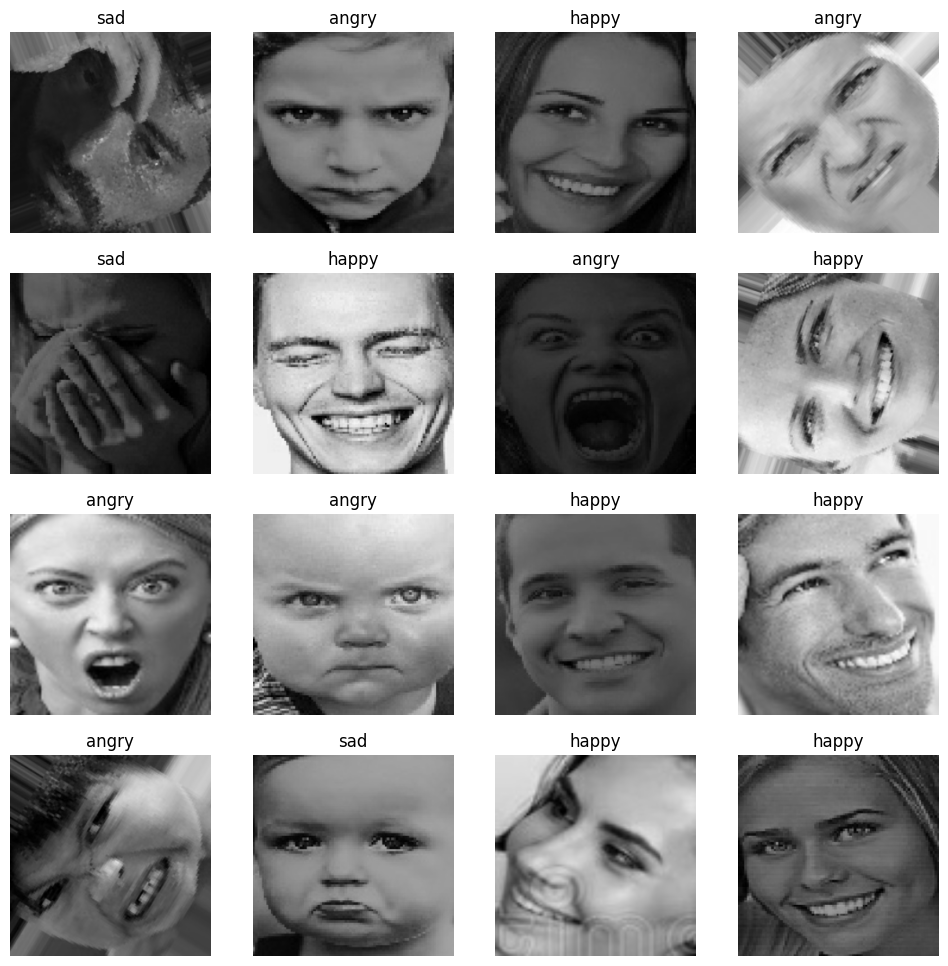

In [11]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

**DATASET PREPARATION**

In [46]:
# train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

# mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [47]:


 # training_dataset = (
 #     mixed_dataset
 #     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
 #     .prefetch(tf.data.AUTOTUNE)
 # )

In [16]:
training_dataset = (
    train_dataset
     .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    # .prefetch(tf.data.AUTOTUNE)
)

In [17]:
validation_dataset = (
    val_dataset
    # .prefetch(tf.data.AUTOTUNE)
)

In [13]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),                 
])

**TFRecord**

In [18]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [19]:
def create_example(image, label):
    
  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))
  
  return example.SerializeToString()

In [20]:
NUM_SHARDS = 10
PATH = 'F:\GITHUB/TensorKerasLabs/HUMAN_EMOTION_DETECTION/TFRecord and tf.train/tfrecords/shard_{:02d}.tfrecord'

In [21]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [22]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [23]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:
      
      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [24]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )

In [25]:
def parse_tfrecords(example):
  
    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }
    
    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [26]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [27]:
parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [35]:
for i in parsed_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.04705883, 0.04705883, 0.04705883],
         [0.        , 0.        , 0.        ],
         [0.76470596, 0.76470596, 0.76470596],
         ...,
         [0.6627451 , 0.6627451 , 0.6627451 ],
         [0.9803922 , 0.9803922 , 0.9803922 ],
         [0.6509804 , 0.6509804 , 0.6509804 ]],

        [[0.34509805, 0.34509805, 0.34509805],
         [0.3921569 , 0.3921569 , 0.3921569 ],
         [0.34901962, 0.34901962, 0.34901962],
         ...,
         [0.03137255, 0.03137255, 0.03137255],
         [0.5372549 , 0.5372549 , 0.5372549 ],
         [0.7019608 , 0.7019608 , 0.7019608 ]],

        [[0.97647065, 0.97647065, 0.97647065],
         [0.5411765 , 0.5411765 , 0.5411765 ],
         [0.454902  , 0.454902  , 0.454902  ],
         ...,
         [0.18823531, 0.18823531, 0.18823531],
         [0.0627451 , 0.0627451 , 0.0627451 ],
         [0.6313726 , 0.6313726 , 0.6313726 ]],

        ...,

        [[0.09019608, 0.09019608

**DATA AUGUMENTATION**

In [14]:
# augment_layers = tf.keras.Sequential([
#   RandomRotation(factor = (-0.025, 0.025)),
#   RandomFlip(mode='horizontal',),
#   RandomContrast(factor=0.1),                   
# ])

In [15]:
# def augment_layer(image, label):
#   return augment_layers(image, training = True), label

**CUTMIX AUGUMENTATION**

In [54]:
# def box(lamda):
  
#   r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
#   r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

#   r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
#   r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

#   r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
#   r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

#   x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
#   y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

#   r_w = x_b_r - r_x
#   if(r_w == 0):
#     r_w  = 1

#   r_h = y_b_r - r_y
#   if(r_h == 0):
#     r_h = 1

#   return r_y, r_x, r_h, r_w

In [55]:
# def cutmix(train_dataset_1, train_dataset_2):
#   (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

#   lamda = tfp.distributions.Beta(2,2)
#   lamda = lamda.sample(1)[0]
  
#   r_y, r_x, r_h, r_w = box(lamda)
#   crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
#   pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

#   crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
#   pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

#   image = image_1 - pad_1 + pad_2

#   lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
#   label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

#   return image, label

**MODELING**

In [39]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_8 (Batc  (None, 254, 254, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 16)     

**TRAIN**

In [41]:
loss_function = SparseCategoricalCrossentropy()

In [42]:


metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]
    

In [43]:
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [44]:
history = lenet_model.fit(
  parsed_dataset,
  # validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_4/batch_normalization_8/FusedBatchNormV3' defined at (most recent call last):
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\aksha\AppData\Local\Temp\ipykernel_23056\521839554.py", line 1, in <module>
      history = lenet_model.fit(
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "D:\Installation_path\ANACONDA\envs\GPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_4/batch_normalization_8/FusedBatchNormV3'
OOM when allocating tensor with shape[32,6,254,254] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_4/batch_normalization_8/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_21864]

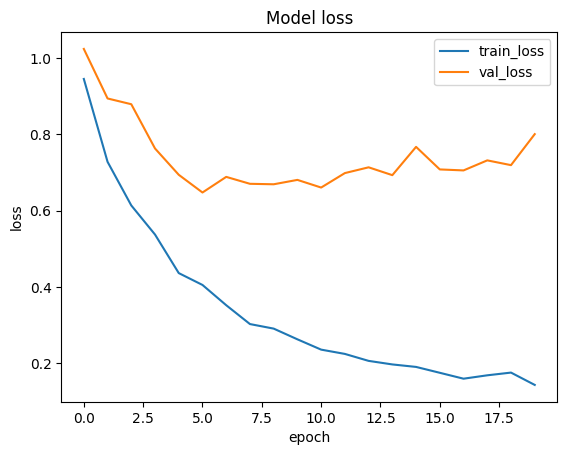

In [61]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

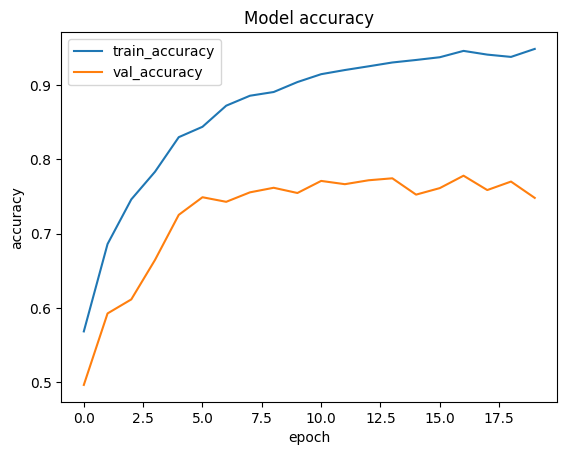

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [63]:
lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 2s 23ms/step - loss: 0.8003 - accuracy: 0.7480 - top_k_accuracy: 0.9122


[0.8003209829330444, 0.748024582862854, 0.9122036695480347]

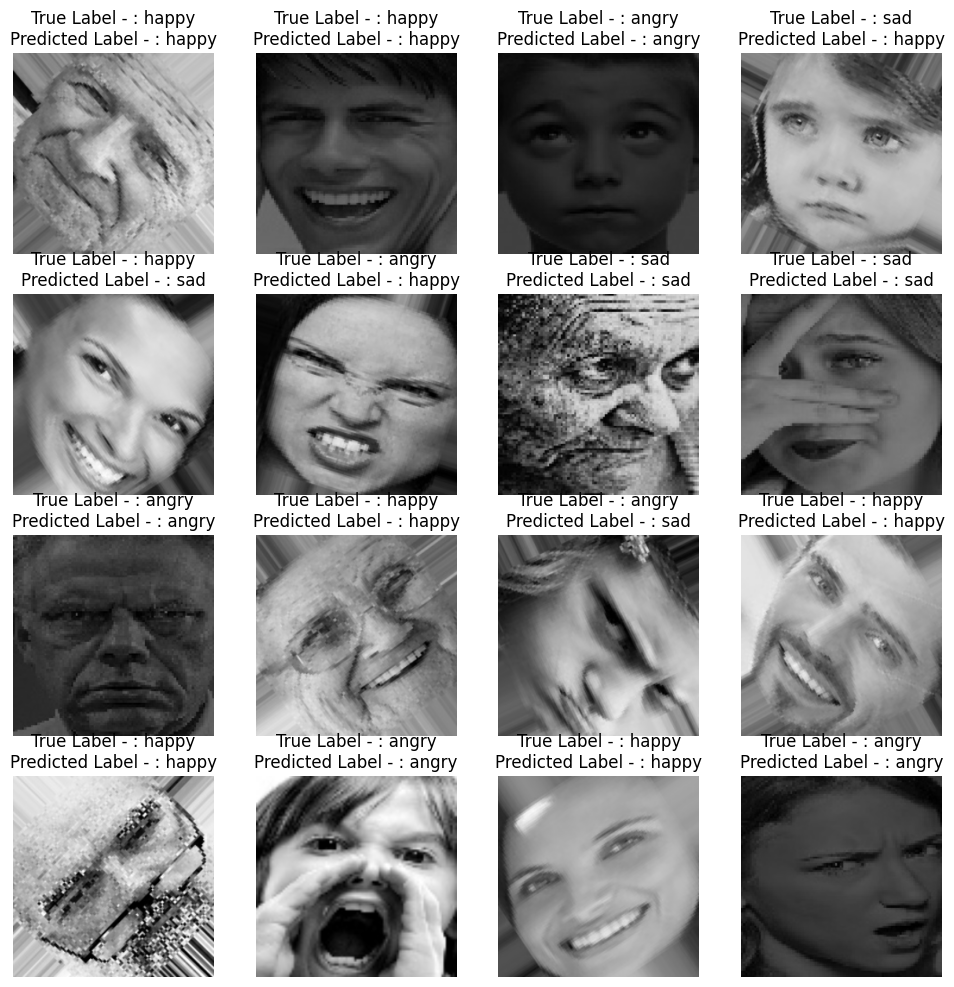

In [64]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")